In [1]:
import uproot
import uproot_methods.classes.TLorentzVector as LVepm
import matplotlib.pyplot as plt
import time
import infofile
import numpy as np
import mplhep as hep

In [2]:
def get_xsec_weight(sample):
    info = infofile.infos[sample] # open infofile
    #print("sample =  " + str(sample) + str(info["xsec"]) + " " +  str(info) )
    xsec_weight = (lumi*1000*info["xsec"])/(info["sumw"]*info["red_eff"]) #*1000 to go from fb-1 to pb-1
    return xsec_weight # return cross-section weight

In [3]:
files = [
"mc_361106.Zee.4lep.root",
"mc_361107.Zmumu.4lep.root",
"mc_410000.ttbar_lep.4lep.root",
"mc_363490.llll.4lep.root",
"mc_363492.llvv.4lep.root",
"mc_363356.ZqqZll.4lep.root",    
"mc_345060.ggH125_ZZ4lep.4lep.root",
"mc_341964.WH125_ZZ4lep.4lep.root",
"mc_344235.VBFH125_ZZ4lep.4lep.root",
"mc_341947.ZH125_ZZ4lep.4lep.root",
"data.4lep.root"  
]

File has been successfully opened!
Sample Name = mc_361106.Zee.4lep.root exp. num. events = 30.389212
File has been successfully opened!
Sample Name = mc_361107.Zmumu.4lep.root exp. num. events = 41.127514
File has been successfully opened!
Sample Name = mc_410000.ttbar_lep.4lep.root exp. num. events = 10.320093
File has been successfully opened!
Sample Name = mc_363490.llll.4lep.root exp. num. events = 245.95114
File has been successfully opened!
Sample Name = mc_363492.llvv.4lep.root exp. num. events = 0.14646414
File has been successfully opened!
Sample Name = mc_363356.ZqqZll.4lep.root exp. num. events = 0.15270728
File has been successfully opened!
File has been successfully opened!
File has been successfully opened!
File has been successfully opened!
File has been successfully opened!
['Zee', 'Zmumu', 'ttbar_lep', 'llll', 'llvv', 'ZqqZll', 'ggH125_ZZ4lep', 'WH125_ZZ4lep', 'VBFH125_ZZ4lep', 'ZH125_ZZ4lep', '4lep']


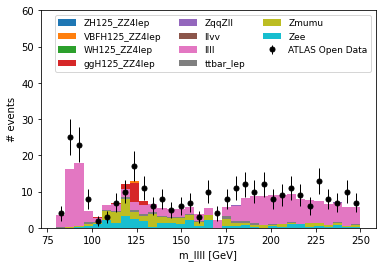

In [9]:
lumi = 10#fb^-1
nBins = 34
minMass = 80
maxMass = 250

bins_ar = np.linspace(minMass, maxMass, num=nBins)
mc_hist_list = []
sample_names = []

f = plt.figure()

H_125 = np.zeros([nBins-1])
H_bkg = np.zeros([nBins-1])

btagWP77 = 0.6459



for file in files:
    sample_name = file.split(".")[1] 
    sample_names.append(sample_name)
    tree = uproot.open(file)["mini"]

    mcWeight, SumWeights, XSection, trigM, trigE, scaleFactor_PILEUP, scaleFactor_ELE, scaleFactor_MUON,scaleFactor_LepTRIGGER, lep_type, lep_pt, lep_eta, lep_phi, lep_E, lep_charge, lep_etcone20, lep_ptcone30, jet_n, jet_pt, jet_eta, jet_phi, jet_E, jet_MV2c10 = tree.arrays(["mcWeight", "SumWeights", "XSection","trigM", "trigE","scaleFactor_PILEUP", "scaleFactor_ELE", "scaleFactor_MUON","scaleFactor_LepTRIGGER","lep_type","lep_pt", "lep_eta","lep_phi", "lep_E", "lep_charge", "lep_etcone20", "lep_ptcone30", "jet_n", "jet_pt", "jet_eta", "jet_phi","jet_E", "jet_MV2c10"], outputtype=tuple)
    print("File has been successfully opened!")
    
    leplv = LVepm.TLorentzVectorArray.from_ptetaphi(lep_pt, lep_eta, lep_phi, lep_E)

    lep_reliso_pt = (lep_ptcone30 / lep_pt)
    lep_reliso_et = (lep_etcone20 / lep_pt)
    sum_lep_type = lep_type.sum()
    
    jetlv = LVepm.TLorentzVectorArray.from_ptetaphi(jet_pt, jet_eta, jet_phi, jet_E)
    jetlv = jetlv[jet_MV2c10.argsort()]    
    tags = jet_pt[jet_MV2c10 > btagWP77]

    trig_cut = ( (trigM==1) | (trigE==1))
    lep_kinematics_cut  = ( (lep_pt.max() > 20000) & (lep_pt.min() > 7000) & (lep_eta.min() >-2.5) & (lep_eta.max() < 2.5))
    lep_type_cut  = ((sum_lep_type == 44) | (sum_lep_type == 48) | (sum_lep_type == 52))
    lep_iso_cut =  ((lep_reliso_pt.max() < 0.3) & (lep_reliso_pt.max() < 0.3))
    lept_count_cut = (leplv.counts ==4)
    lept_charge_cut = (lep_charge.sum()==0)
    
    event_cut = ( lep_kinematics_cut & lep_type_cut & lep_iso_cut  & lept_count_cut &lept_charge_cut)

    first_lep_p4 =  leplv[event_cut,0]
    second_lep_p4 = leplv[event_cut,1]
    third_lep_p4 =  leplv[event_cut,2]
    fourth_lep_p4 = leplv[event_cut,3]
    mcWeight = mcWeight[event_cut] 
    
    scaleFactor_PILEUP = scaleFactor_PILEUP[event_cut] 
    scaleFactor_ELE = scaleFactor_ELE[event_cut] 
    scaleFactor_MUON = scaleFactor_MUON[event_cut] 
    scaleFactor_LepTRIGGER = scaleFactor_LepTRIGGER[event_cut] 
    
    llll_p4 = first_lep_p4 + second_lep_p4 + third_lep_p4 + fourth_lep_p4   
    
    if(file.split("_")[0] == "mc"):
        finalWeight = get_xsec_weight(sample_name)*(mcWeight)*(scaleFactor_PILEUP)*(scaleFactor_ELE) *(scaleFactor_MUON)*(scaleFactor_LepTRIGGER)
        H, b = np.histogram(llll_p4.mass/1000.0, weights=finalWeight, bins=bins_ar)                        
        mc_hist_list.append(H)
        if("H125" in file):
            H_125 = np.add(H, H_125)
        else:
            print("Sample Name = " + str(file) + " exp. num. events = " + str(np.sum(finalWeight)) )
            H_bkg = np.add(H, H_bkg)
    
    else:
        finalWeight = np.ones(len(mcWeight)) 
        sample_name = "Data (10 fb^-1)"
        H_data, b = np.histogram(llll_p4.mass/1000.0, weights=finalWeight, bins=bins_ar)
        
print(sample_names)
#hep.histplot([H_bkg, H_125], bins=bins_ar, stack=True, label=["Backgrounds", "Higgs"], histtype='fill')
#hep.histplot([H_bkg], bins=bins_ar, stack=True, label="Backgrounds", histtype='fill')

hep.histplot(mc_hist_list, bins=bins_ar, stack=True, label=sample_names[:-1], histtype='fill')
hep.histplot([H_data], bins=bins_ar, stack=False, yerr=True, histtype="errorbar", color="black",label="ATLAS Open Data")

plt.legend(loc=1, ncol=3, fontsize=9)
plt.xlabel("m_llll [GeV]")
plt.ylabel("# events")
#plt.yscale("log")
plt.ylim([0.0, 60])
plt.show()